In [ ]:
#| default_exp models.tft

# TFT

In summary Temporal Fusion Transformer (TFT) combines gating layers, an LSTM recurrent encoder, with multi-head attention layers for a multi-step forecasting strategy decoder.<br>TFT's inputs are static exogenous $\mathbf{x}^{(s)}$, historic exogenous $\mathbf{x}^{(h)}_{[:t]}$, exogenous available at the time of the prediction $\mathbf{x}^{(f)}_{[:t+H]}$ and autorregresive features $\mathbf{y}_{[:t]}$, each of these inputs is further decomposed into categorical and continuous. The network uses a multi-quantile regression to model the following conditional probability:$$\mathbb{P}(\mathbf{y}_{[t+1:t+H]}|\;\mathbf{y}_{[:t]},\; \mathbf{x}^{(h)}_{[:t]},\; \mathbf{x}^{(f)}_{[:t+H]},\; \mathbf{x}^{(s)})$$

**References**<br>
- [Jan Golda, Krzysztof Kudrynski. "NVIDIA, Deep Learning Forecasting Examples"](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Forecasting/TFT)<br>
- [Bryan Lim, Sercan O. Arik, Nicolas Loeff, Tomas Pfister, "Temporal Fusion Transformers for interpretable multi-horizon time series forecasting"](https://www.sciencedirect.com/science/article/pii/S0169207021000637)<br>

![Figure 1. Temporal Fusion Transformer Architecture.](imgs_models/tft_architecture.png)

In [ ]:
#| export
from typing import Tuple, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.nn import LayerNorm
import pandas as pd
from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_windows import BaseWindows

In [ ]:
#| hide
import logging
import warnings

from fastcore.test import test_eq
from nbdev.showdoc import show_doc

In [ ]:
#| hide
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

## 1. Auxiliary Functions

### 1.1 Gating Mechanisms

The Gated Residual Network (GRN) provides adaptive depth and network complexity capable of accommodating different size datasets. As residual connections allow for the network to skip the non-linear transformation of input $\mathbf{a}$ and context $\mathbf{c}$.

\begin{align}
\eta_{1} &= \mathrm{ELU}(\mathbf{W}_{1}\mathbf{a}+\mathbf{W}_{2}\mathbf{c}+\mathbf{b}_{1}) \\
\eta_{2} &= \mathbf{W}_{2}\eta_{1}+b_{2} \\
\mathrm{GRN}(\mathbf{a}, \mathbf{c}) &= \mathrm{LayerNorm}(a + \textrm{GLU}(\eta_{2}))
\end{align}

The Gated Linear Unit (GLU) provides the flexibility of supressing unnecesary parts of the GRN. Consider GRN's output $\gamma$ then GLU transformation is defined by:

$$\mathrm{GLU}(\gamma) = \sigma(\mathbf{W}_{4}\gamma +b_{4}) \odot (\mathbf{W}_{5}\gamma +b_{5})$$

![Figure 2. Gated Residual Network.](imgs_models/tft_grn.png)

In [ ]:
#| exporti
class MaybeLayerNorm(nn.Module):
    def __init__(self, output_size, hidden_size, eps):
        super().__init__()
        if output_size and output_size == 1:
            self.ln = nn.Identity()
        else:
            self.ln = LayerNorm(output_size if output_size else hidden_size,
                                eps=eps)

    def forward(self, x):
        return self.ln(x)

class GLU(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.lin = nn.Linear(hidden_size, output_size * 2)

    def forward(self, x: Tensor) -> Tensor:
        x = self.lin(x)
        x = F.glu(x)
        return x

class GRN(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size, 
                 output_size=None,
                 context_hidden_size=None,
                 dropout=0):
        super().__init__()
        
        self.layer_norm = MaybeLayerNorm(output_size, hidden_size, eps=1e-3)
        self.lin_a = nn.Linear(input_size, hidden_size)
        if context_hidden_size is not None:
            self.lin_c = nn.Linear(context_hidden_size, hidden_size, bias=False)
        self.lin_i = nn.Linear(hidden_size, hidden_size)
        self.glu = GLU(hidden_size, output_size if output_size else hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(input_size, output_size) if output_size else None

    def forward(self, a: Tensor, c: Optional[Tensor] = None):
        x = self.lin_a(a)
        if c is not None:
            x = x + self.lin_c(c).unsqueeze(1)
        x = F.elu(x)
        x = self.lin_i(x)
        x = self.dropout(x)
        x = self.glu(x)
        y = a if not self.out_proj else self.out_proj(a)
        x = x + y
        x = self.layer_norm(x)
        return x

### 1.2 Variable Selection Networks

TFT includes automated variable selection capabilities, through its variable selection network (VSN) components. The VSN takes the original input $\{\mathbf{x}^{(s)}, \mathbf{x}^{(h)}_{[:t]}, \mathbf{x}^{(f)}_{[:t]}\}$ and transforms it through embeddings or linear transformations into a high dimensional space
$\{\mathbf{E}^{(s)}, \mathbf{E}^{(h)}_{[:t]}, \mathbf{E}^{(f)}_{[:t+H]}\}$. 

For the observed historic data, the embedding matrix $\mathbf{E}^{(h)}_{t}$ at time $t$ is a concatenation of $j$ variable $e^{(h)}_{t,j}$ embeddings:
\begin{align}
\mathbf{E}^{(h)}_{t} &= [e^{(h)}_{t,1},\dots,e^{(h)}_{t,j},\dots,e^{(h)}_{t,n_{h}}] \\
\mathbf{\tilde{e}}^{(h)}_{t,j} &= \mathrm{GRN}(e^{(h)}_{t,j})
\end{align}

The variable selection weights are given by:
$$s^{(h)}_{t}=\mathrm{SoftMax}(\mathrm{GRN}(\mathbf{E}^{(h)}_{t},\mathbf{E}^{(s)}))$$

The VSN processed features are then:
$$\tilde{\mathbf{E}}^{(h)}_{t}= \sum_{j} s^{(h)}_{j} \tilde{e}^{(h)}_{t,j}$$

![Figure 3. Variable Selection Network.](imgs_models/tft_vsn.png)

In [ ]:
#| exporti
class TFTEmbedding(nn.Module):
    def __init__(self, hidden_size, stat_input_size, futr_input_size, hist_input_size, tgt_size):
        super().__init__()
        # There are 4 types of input:
        # 1. Static continuous
        # 2. Temporal known a priori continuous
        # 3. Temporal observed continuous
        # 4. Temporal observed targets (time series obseved so far)

        self.hidden_size = hidden_size

        self.stat_input_size = stat_input_size
        self.futr_input_size = futr_input_size
        self.hist_input_size = hist_input_size
        self.tgt_size        = tgt_size

        # Instantiate Continuous Embeddings if size is not None
        for attr, size in [('stat_exog_embedding', stat_input_size), 
                           ('futr_exog_embedding', futr_input_size),
                           ('hist_exog_embedding', hist_input_size),
                           ('tgt_embedding', tgt_size)]:
            if size:
                vectors = nn.Parameter(torch.Tensor(size, hidden_size))
                bias = nn.Parameter(torch.zeros(size, hidden_size))
                torch.nn.init.xavier_normal_(vectors)
                setattr(self, attr+'_vectors', vectors)
                setattr(self, attr+'_bias', bias)
            else:
                setattr(self, attr+'_vectors', None)
                setattr(self, attr+'_bias', None)

    def _apply_embedding(self,
                         cont: Optional[Tensor],
                         cont_emb: Tensor,
                         cont_bias: Tensor,
                         ):

        if (cont is not None):
            #the line below is equivalent to following einsums
            #e_cont = torch.einsum('btf,fh->bthf', cont, cont_emb)
            #e_cont = torch.einsum('bf,fh->bhf', cont, cont_emb)          
            e_cont = torch.mul(cont.unsqueeze(-1), cont_emb)
            e_cont = e_cont + cont_bias
            return e_cont
        
        return None

    def forward(self, target_inp, 
                stat_exog=None, futr_exog=None, hist_exog=None):
        # temporal/static categorical/continuous known/observed input 
        # tries to get input, if fails returns None

        # Static inputs are expected to be equal for all timesteps
        # For memory efficiency there is no assert statement
        stat_exog = stat_exog[:,:] if stat_exog is not None else None

        s_inp = self._apply_embedding(cont=stat_exog,
                                      cont_emb=self.stat_exog_embedding_vectors,
                                      cont_bias=self.stat_exog_embedding_bias)
        k_inp = self._apply_embedding(cont=futr_exog,
                                      cont_emb=self.futr_exog_embedding_vectors,
                                      cont_bias=self.futr_exog_embedding_bias)
        o_inp = self._apply_embedding(cont=hist_exog,
                                      cont_emb=self.hist_exog_embedding_vectors,
                                      cont_bias=self.hist_exog_embedding_bias)

        # Temporal observed targets
        # t_observed_tgt = torch.einsum('btf,fh->btfh', 
        #                               target_inp, self.tgt_embedding_vectors)        
        target_inp = torch.matmul(target_inp.unsqueeze(3).unsqueeze(4),
                          self.tgt_embedding_vectors.unsqueeze(1)).squeeze(3)
        target_inp = target_inp + self.tgt_embedding_bias

        return s_inp, k_inp, o_inp, target_inp

class VariableSelectionNetwork(nn.Module):
    def __init__(self, hidden_size, num_inputs, dropout):
        super().__init__()
        self.joint_grn = GRN(input_size=hidden_size*num_inputs, 
                             hidden_size=hidden_size, 
                             output_size=num_inputs, 
                             context_hidden_size=hidden_size)
        self.var_grns = nn.ModuleList(
                        [GRN(input_size=hidden_size, 
                             hidden_size=hidden_size, dropout=dropout)
                         for _ in range(num_inputs)])

    def forward(self, x: Tensor, context: Optional[Tensor] = None):
        Xi = x.reshape(*x.shape[:-2], -1)
        grn_outputs = self.joint_grn(Xi, c=context)
        sparse_weights = F.softmax(grn_outputs, dim=-1)
        transformed_embed_list = [m(x[...,i,:])
                                     for i, m in enumerate(self.var_grns)]
        transformed_embed = torch.stack(transformed_embed_list, dim=-1)
        #the line below performs batched matrix vector multiplication
        #for temporal features it's bthf,btf->bth
        #for static features it's bhf,bf->bh
        variable_ctx = torch.matmul(transformed_embed, 
                                    sparse_weights.unsqueeze(-1)).squeeze(-1)

        return variable_ctx, sparse_weights

### 1.3. Multi-Head Attention

To avoid information bottlenecks from the classic Seq2Seq architecture, TFT 
incorporates a decoder-encoder attention mechanism inherited transformer architectures ([Li et. al 2019](https://arxiv.org/abs/1907.00235), [Vaswani et. al 2017](https://arxiv.org/abs/1706.03762)). It transform the the outputs of the LSTM encoded temporal features, and helps the decoder better capture long-term relationships.

The original multihead attention for each component $H_{m}$ and its query, key, and value representations are denoted by $Q_{m}, K_{m}, V_{m}$, its transformation is given by:

\begin{align}
Q_{m} = Q W_{Q,m} \quad K_{m} = K W_{K,h} \quad V_{m} = V W_{V,m} \\
H_{m}=\mathrm{Attention}(Q_{m}, K_{m}, V_{m}) = \mathrm{SoftMax}(Q_{m} K^{\intercal}_{m}/\mathrm{scale}) \; V_{m} \\
\mathrm{MultiHead}(Q, K, V) = [H_{1},\dots,H_{M}] W_{M}
\end{align}

TFT modifies the original multihead attention to improve its interpretability. To do it it uses shared values $\tilde{V}$ across heads and employs additive aggregation, $\mathrm{InterpretableMultiHead}(Q,K,V) = \tilde{H} W_{M}$. The mechanism has a great resemblence to a single attention layer, but it allows for $M$ multiple attention weights, and can be therefore be interpreted as the average ensemble of $M$ single attention layers.

\begin{align}
\tilde{H} &= \left(\frac{1}{M} \sum_{m} \mathrm{SoftMax}(Q_{m} K^{\intercal}_{m}/\mathrm{scale}) \right) \tilde{V} 
          = \frac{1}{M} \sum_{m} \mathrm{Attention}(Q_{m}, K_{m}, \tilde{V}) \\
\end{align}

In [ ]:
#| exporti
class InterpretableMultiHeadAttention(nn.Module):
    def __init__(self, n_head, hidden_size, example_length, attn_dropout, dropout):
        super().__init__()
        self.n_head = n_head
        assert hidden_size % n_head == 0
        self.d_head = hidden_size // n_head
        self.qkv_linears = nn.Linear(
            hidden_size, (2 * self.n_head + 1) * self.d_head, bias=False
        )
        self.out_proj = nn.Linear(self.d_head, hidden_size, bias=False)

        self.attn_dropout = nn.Dropout(attn_dropout)
        self.out_dropout = nn.Dropout(dropout)
        self.scale = self.d_head**-0.5
        self.register_buffer(
            "_mask",
            torch.triu(
                torch.full((example_length, example_length), float("-inf")), 1
            ).unsqueeze(0),
        )

    def forward(
        self, x: Tensor, mask_future_timesteps: bool = True
    ) -> Tuple[Tensor, Tensor]:
        # [Batch,Time,MultiHead,AttDim] := [N,T,M,AD]
        bs, t, h_size = x.shape
        qkv = self.qkv_linears(x)
        q, k, v = qkv.split(
            (self.n_head * self.d_head, self.n_head * self.d_head, self.d_head), dim=-1
        )
        q = q.view(bs, t, self.n_head, self.d_head)
        k = k.view(bs, t, self.n_head, self.d_head)
        v = v.view(bs, t, self.d_head)

        # [N,T1,M,Ad] x [N,T2,M,Ad] -> [N,M,T1,T2]
        # attn_score = torch.einsum('bind,bjnd->bnij', q, k)
        attn_score = torch.matmul(q.permute((0, 2, 1, 3)), k.permute((0, 2, 3, 1)))
        attn_score.mul_(self.scale)

        if mask_future_timesteps:
            attn_score = attn_score + self._mask

        attn_prob = F.softmax(attn_score, dim=3)
        attn_prob = self.attn_dropout(attn_prob)

        # [N,M,T1,T2] x [N,M,T1,Ad] -> [N,M,T1,Ad]
        # attn_vec = torch.einsum('bnij,bjd->bnid', attn_prob, v)
        attn_vec = torch.matmul(attn_prob, v.unsqueeze(1))
        m_attn_vec = torch.mean(attn_vec, dim=1)
        out = self.out_proj(m_attn_vec)
        out = self.out_dropout(out)

        return out, attn_prob

## 2. TFT Architecture

The first TFT's step is embed the original input $\{\mathbf{x}^{(s)}, \mathbf{x}^{(h)}, \mathbf{x}^{(f)}\}$ into a high dimensional space $\{\mathbf{E}^{(s)}, \mathbf{E}^{(h)}, \mathbf{E}^{(f)}\}$, after which each embedding is gated by a variable selection network (VSN). The static embedding $\mathbf{E}^{(s)}$ is used as context for variable selection and as initial condition to the LSTM. Finally the encoded variables are fed into the multi-head attention decoder.

\begin{align}
 c_{s}, c_{e}, (c_{h}, c_{c}) &=\textrm{StaticCovariateEncoder}(\mathbf{E}^{(s)}) \\ 
      h_{[:t]}, h_{[t+1:t+H]}  &=\textrm{TemporalCovariateEncoder}(\mathbf{E}^{(h)}, \mathbf{E}^{(f)}, c_{h}, c_{c}) \\
\hat{\mathbf{y}}^{(q)}_{[t+1:t+H]} &=\textrm{TemporalFusionDecoder}(h_{[t+1:t+H]}, c_{e})
\end{align}

### 2.1 Static Covariate Encoder

The static embedding $\mathbf{E}^{(s)}$ is transformed by the StaticCovariateEncoder into contexts $c_{s}, c_{e}, c_{h}, c_{c}$. Where $c_{s}$ are temporal variable selection contexts, $c_{e}$ are TemporalFusionDecoder enriching contexts, and $c_{h}, c_{c}$ are LSTM's hidden/contexts for the TemporalCovariateEncoder.

\begin{align}
c_{s}, c_{e}, (c_{h}, c_{c}) & = \textrm{GRN}(\textrm{VSN}(\mathbf{E}^{(s)}))
\end{align}

In [ ]:
#| exporti
class StaticCovariateEncoder(nn.Module):
    def __init__(self, hidden_size, num_static_vars, dropout):
        super().__init__()
        self.vsn = VariableSelectionNetwork(
            hidden_size=hidden_size, num_inputs=num_static_vars, dropout=dropout
        )
        self.context_grns = nn.ModuleList(
            [
                GRN(input_size=hidden_size, hidden_size=hidden_size, dropout=dropout)
                for _ in range(4)
            ]
        )

    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor, Tensor, Tensor]:
        variable_ctx, sparse_weights = self.vsn(x)

        # Context vectors:
        # variable selection context
        # enrichment context
        # state_c context
        # state_h context
        cs, ce, ch, cc = tuple(m(variable_ctx) for m in self.context_grns) # type: ignore

        return cs, ce, ch, cc, sparse_weights # type: ignore

### 2.2 Temporal Covariate Encoder

TemporalCovariateEncoder encodes the embeddings $\mathbf{E}^{(h)}, \mathbf{E}^{(f)}$ and contexts  $(c_{h}, c_{c})$ with an LSTM.

\begin{align}
\tilde{\mathbf{E}}^{(h)}_{[:t]} & = \textrm{VSN}(\mathbf{E}^{(h)}_{[:t]}, c_{s}) \\
\tilde{\mathbf{E}}^{(h)}_{[:t]} &= \mathrm{LSTM}(\tilde{\mathbf{E}}^{(h)}_{[:t]}, (c_{h}, c_{c})) \\
h_{[:t]} &= \mathrm{Gate}(\mathrm{LayerNorm}(\tilde{\mathbf{E}}^{(h)}_{[:t]}))
\end{align}

An analogous process is repeated for the future data, with the main difference that $\mathbf{E}^{(f)}$ contains the future available information.

\begin{align}
\tilde{\mathbf{E}}^{(f)}_{[t+1:t+h]} & = \textrm{VSN}(\mathbf{E}^{(h)}_{t+1:t+H}, \mathbf{E}^{(f)}_{t+1:t+H}, c_{s}) \\
\tilde{\mathbf{E}}^{(f)}_{[t+1:t+h]} &= \mathrm{LSTM}(\tilde{\mathbf{E}}^{(h)}_{[t+1:t+h]}, (c_{h}, c_{c})) \\
h_{[t+1:t+H]} &= \mathrm{Gate}(\mathrm{LayerNorm}(\tilde{\mathbf{E}}^{(f)}_{[t+1:t+h]}))
\end{align}

In [ ]:
#| exporti
class TemporalCovariateEncoder(nn.Module):
    def __init__(self, hidden_size, num_historic_vars, num_future_vars, dropout):
        super(TemporalCovariateEncoder, self).__init__()

        self.history_vsn = VariableSelectionNetwork(
            hidden_size=hidden_size, num_inputs=num_historic_vars, dropout=dropout
        )
        self.history_encoder = nn.LSTM(
            input_size=hidden_size, hidden_size=hidden_size, batch_first=True
        )

        self.future_vsn = VariableSelectionNetwork(
            hidden_size=hidden_size, num_inputs=num_future_vars, dropout=dropout
        )
        self.future_encoder = nn.LSTM(
            input_size=hidden_size, hidden_size=hidden_size, batch_first=True
        )

        # Shared Gated-Skip Connection
        self.input_gate = GLU(hidden_size, hidden_size)
        self.input_gate_ln = LayerNorm(hidden_size, eps=1e-3)

    def forward(self, historical_inputs, future_inputs, cs, ch, cc):
        # [N,X_in,L] -> [N,hidden_size,L]
        historical_features, history_vsn_sparse_weights = self.history_vsn(
            historical_inputs, cs
        )
        history, state = self.history_encoder(historical_features, (ch, cc))

        future_features, future_vsn_sparse_weights = self.future_vsn(future_inputs, cs)
        future, _ = self.future_encoder(future_features, state)
        # torch.cuda.synchronize() # this call gives prf boost for unknown reasons

        input_embedding = torch.cat([historical_features, future_features], dim=1)
        temporal_features = torch.cat([history, future], dim=1)
        temporal_features = self.input_gate(temporal_features)
        temporal_features = temporal_features + input_embedding
        temporal_features = self.input_gate_ln(temporal_features)
        return temporal_features, history_vsn_sparse_weights, future_vsn_sparse_weights

### 2.3 Temporal Fusion Decoder

The TemporalFusionDecoder enriches the LSTM's outputs with $c_{e}$ and then uses an attention layer, and multi-step adapter.
\begin{align}
h_{[t+1:t+H]} &= \mathrm{MultiHeadAttention}(h_{[:t]}, h_{[t+1:t+H]}, c_{e}) \\
h_{[t+1:t+H]} &= \mathrm{Gate}(\mathrm{LayerNorm}(h_{[t+1:t+H]}) \\
h_{[t+1:t+H]} &= \mathrm{Gate}(\mathrm{LayerNorm}(\mathrm{GRN}(h_{[t+1:t+H]})) \\
\hat{\mathbf{y}}^{(q)}_{[t+1:t+H]} &= \mathrm{MLP}(h_{[t+1:t+H]})
\end{align}

In [ ]:
#| exporti
class TemporalFusionDecoder(nn.Module):
    def __init__(
        self, n_head, hidden_size, example_length, encoder_length, attn_dropout, dropout
    ):
        super(TemporalFusionDecoder, self).__init__()
        self.encoder_length = encoder_length

        # ------------- Encoder-Decoder Attention --------------#
        self.enrichment_grn = GRN(
            input_size=hidden_size,
            hidden_size=hidden_size,
            context_hidden_size=hidden_size,
            dropout=dropout,
        )
        self.attention = InterpretableMultiHeadAttention(
            n_head=n_head,
            hidden_size=hidden_size,
            example_length=example_length,
            attn_dropout=attn_dropout,
            dropout=dropout,
        )
        self.attention_gate = GLU(hidden_size, hidden_size)
        self.attention_ln = LayerNorm(normalized_shape=hidden_size, eps=1e-3)

        self.positionwise_grn = GRN(
            input_size=hidden_size, hidden_size=hidden_size, dropout=dropout
        )

        # ---------------------- Decoder -----------------------#
        self.decoder_gate = GLU(hidden_size, hidden_size)
        self.decoder_ln = LayerNorm(normalized_shape=hidden_size, eps=1e-3)

    def forward(self, temporal_features, ce):
        # ------------- Encoder-Decoder Attention --------------#
        # Static enrichment
        enriched = self.enrichment_grn(temporal_features, c=ce)

        # Temporal self attention
        x, atten_vect = self.attention(enriched, mask_future_timesteps=True)

        # Don't compute historical quantiles
        x = x[:, self.encoder_length :, :]
        temporal_features = temporal_features[:, self.encoder_length :, :]
        enriched = enriched[:, self.encoder_length :, :]

        x = self.attention_gate(x)
        x = x + enriched
        x = self.attention_ln(x)

        # Position-wise feed-forward
        x = self.positionwise_grn(x)

        # ---------------------- Decoder ----------------------#
        # Final skip connection
        x = self.decoder_gate(x)
        x = x + temporal_features
        x = self.decoder_ln(x)

        return x, atten_vect


In [ ]:
#| export
class TFT(BaseWindows):
    """TFT

    The Temporal Fusion Transformer architecture (TFT) is an Sequence-to-Sequence
    model that combines static, historic and future available data to predict an
    univariate target. The method combines gating layers, an LSTM recurrent encoder,
    with and interpretable multi-head attention layer and a multi-step forecasting
    strategy decoder.

    **Parameters:**<br>
    `h`: int, Forecast horizon. <br>
    `input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
    `stat_exog_list`: str list, static continuous columns.<br>
    `hist_exog_list`: str list, historic continuous columns.<br>
    `futr_exog_list`: str list, future continuous columns.<br>
    `hidden_size`: int, units of embeddings and encoders.<br>
    `dropout`: float (0, 1), dropout of inputs VSNs.<br>
    `n_head`: int=4, number of attention heads in temporal fusion decoder.<br>
    `attn_dropout`: float (0, 1), dropout of fusion decoder's attention layer.<br>
    `shared_weights`: bool, If True, all blocks within each stack will share parameters. <br>
    `activation`: str, activation from ['ReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid'].<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int, number of different series in each batch.<br>
    `windows_batch_size`: int=None, windows sampled from rolled data, default uses all.<br>
    `inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
    `start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int, random seed initialization for replicability.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
    `optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
    `lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
    `lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>

    **References:**<br>
    - [Bryan Lim, Sercan O. Arik, Nicolas Loeff, Tomas Pfister,
    "Temporal Fusion Transformers for interpretable multi-horizon time series forecasting"](https://www.sciencedirect.com/science/article/pii/S0169207021000637)
    """

    # Class attributes
    SAMPLING_TYPE = "windows"
    EXOGENOUS_FUTR = True
    EXOGENOUS_HIST = True
    EXOGENOUS_STAT = True

    def __init__(
        self,
        h,
        input_size,
        tgt_size: int = 1,
        stat_exog_list=None,
        hist_exog_list=None,
        futr_exog_list=None,
        hidden_size: int = 128,
        n_head: int = 4,
        attn_dropout: float = 0.0,
        dropout: float = 0.1,
        loss=MAE(),
        valid_loss=None,
        max_steps: int = 1000,
        learning_rate: float = 1e-3,
        num_lr_decays: int = -1,
        early_stop_patience_steps: int = -1,
        val_check_steps: int = 100,
        batch_size: int = 32,
        valid_batch_size: Optional[int] = None,
        windows_batch_size: int = 1024,
        inference_windows_batch_size: int = 1024,
        start_padding_enabled=False,
        step_size: int = 1,
        scaler_type: str = "robust",
        num_workers_loader=0,
        drop_last_loader=False,
        random_seed: int = 1,
        optimizer=None,
        optimizer_kwargs=None,
        lr_scheduler=None,
        lr_scheduler_kwargs=None,
        **trainer_kwargs,
    ):

        # Inherit BaseWindows class
        super(TFT, self).__init__(
            h=h,
            input_size=input_size,
            stat_exog_list=stat_exog_list,
            hist_exog_list=hist_exog_list,
            futr_exog_list=futr_exog_list,
            loss=loss,
            valid_loss=valid_loss,
            max_steps=max_steps,
            learning_rate=learning_rate,
            num_lr_decays=num_lr_decays,
            early_stop_patience_steps=early_stop_patience_steps,
            val_check_steps=val_check_steps,
            batch_size=batch_size,
            valid_batch_size=valid_batch_size,
            windows_batch_size=windows_batch_size,
            inference_windows_batch_size=inference_windows_batch_size,
            start_padding_enabled=start_padding_enabled,
            step_size=step_size,
            scaler_type=scaler_type,
            num_workers_loader=num_workers_loader,
            drop_last_loader=drop_last_loader,
            random_seed=random_seed,
            optimizer=optimizer,
            optimizer_kwargs=optimizer_kwargs,
            lr_scheduler=lr_scheduler,
            lr_scheduler_kwargs=lr_scheduler_kwargs,
            **trainer_kwargs,
        )
        self.example_length = input_size + h
        self.interpretability_params = dict([]) # type: ignore
        self.tgt_size = tgt_size
        futr_exog_size = max(self.futr_exog_size, 1)
        num_historic_vars = futr_exog_size + self.hist_exog_size + tgt_size

        #------------------------------- Encoders -----------------------------#
        self.embedding = TFTEmbedding(hidden_size=hidden_size,
                                      stat_input_size=self.stat_exog_size,
                                      futr_input_size=futr_exog_size,
                                      hist_input_size=self.hist_exog_size,
                                      tgt_size=tgt_size)
        
        if self.stat_exog_size > 0:
            self.static_encoder = StaticCovariateEncoder(
                                        hidden_size=hidden_size,
                                        num_static_vars=self.stat_exog_size,
                                        dropout=dropout)

        self.temporal_encoder = TemporalCovariateEncoder(
            hidden_size=hidden_size,
            num_historic_vars=num_historic_vars,
            num_future_vars=futr_exog_size,
            dropout=dropout,
        )

        # ------------------------------ Decoders -----------------------------#
        self.temporal_fusion_decoder = TemporalFusionDecoder(
            n_head=n_head,
            hidden_size=hidden_size,
            example_length=self.example_length,
            encoder_length=self.input_size,
            attn_dropout=attn_dropout,
            dropout=dropout,
        )

        # Adapter with Loss dependent dimensions
        self.output_adapter = nn.Linear(
            in_features=hidden_size, out_features=self.loss.outputsize_multiplier
        )

    def forward(self, windows_batch):

        # Parsiw windows_batch
        y_insample = windows_batch["insample_y"][:, :, None]  # <- [B,T,1]
        futr_exog = windows_batch["futr_exog"]
        hist_exog = windows_batch["hist_exog"]
        stat_exog = windows_batch["stat_exog"]

        if futr_exog is None:
            futr_exog = y_insample[:, [-1]]
            futr_exog = futr_exog.repeat(1, self.example_length, 1)

        s_inp, k_inp, o_inp, t_observed_tgt = self.embedding(
            target_inp=y_insample,
            hist_exog=hist_exog,
            futr_exog=futr_exog,
            stat_exog=stat_exog,
        )

        # -------------------------------- Inputs ------------------------------#
        # Static context
        if s_inp is not None:
            cs, ce, ch, cc, static_encoder_sparse_weights = self.static_encoder(s_inp)
            ch, cc = ch.unsqueeze(0), cc.unsqueeze(0)  # LSTM initial states
        else:
            # If None add zeros
            batch_size, example_length, target_size, hidden_size = t_observed_tgt.shape
            cs = torch.zeros(size=(batch_size, hidden_size), device=y_insample.device)
            ce = torch.zeros(size=(batch_size, hidden_size), device=y_insample.device)
            ch = torch.zeros(
                size=(1, batch_size, hidden_size), device=y_insample.device
            )
            cc = torch.zeros(
                size=(1, batch_size, hidden_size), device=y_insample.device
            )
            static_encoder_sparse_weights = []

        # Historical inputs
        _historical_inputs = [
            k_inp[:, : self.input_size, :],
            t_observed_tgt[:, : self.input_size, :],
        ]
        if o_inp is not None:
            _historical_inputs.insert(0, o_inp[:, : self.input_size, :])
        historical_inputs = torch.cat(_historical_inputs, dim=-2)
        # Future inputs
        future_inputs = k_inp[:, self.input_size :]

        # ---------------------------- Encode/Decode ---------------------------#
        # Embeddings + VSN + LSTM encoders
        temporal_features, history_vsn_wgts, future_vsn_wgts = self.temporal_encoder(
            historical_inputs=historical_inputs,
            future_inputs=future_inputs,
            cs=cs,
            ch=ch,
            cc=cc,
        )

        # Static enrichment, Attention and decoders
        temporal_features, attn_wts = self.temporal_fusion_decoder(
            temporal_features=temporal_features, ce=ce
        )

        # Store params
        self.interpretability_params = {
            "history_vsn_wgts": history_vsn_wgts,
            "future_vsn_wgts": future_vsn_wgts,
            "static_encoder_sparse_weights": static_encoder_sparse_weights,
            "attn_wts": attn_wts,
        }

        # Adapt output to loss
        y_hat = self.output_adapter(temporal_features)
        y_hat = self.loss.domain_map(y_hat)

        return y_hat

    def mean_on_batch(self, tensor):
        batch_size = tensor.size(0)
        if batch_size > 1:
            return tensor.mean(dim=0)
        else:
            return tensor.squeeze(0)

    def feature_importances(self):
        """
        Compute the feature importances for historical, future, and static features.

        Returns:
            dict: A dictionary containing the feature importances for each feature type.
                The keys are 'hist_vsn', 'future_vsn', and 'static_vsn', and the values
                are pandas DataFrames with the corresponding feature importances.
        """
        if not self.interpretability_params:
            raise ValueError(
                "No interpretability_params. Make a prediction using the model to generate them."
            )

        importances = {}

        # Historical feature importances
        hist_vsn_wgts = self.interpretability_params.get("history_vsn_wgts")
        hist_exog_list = list(self.hist_exog_list) + list(self.futr_exog_list)
        hist_exog_list += (
            [f"observed_target_{i+1}" for i in range(self.tgt_size)]
            if self.tgt_size > 1
            else ["observed_target"]
        )
        if len(self.futr_exog_list) < 1:
            hist_exog_list += ["repeated_target"]
        hist_vsn_imp = pd.DataFrame(
            self.mean_on_batch(hist_vsn_wgts).cpu().numpy(), columns=hist_exog_list
        )
        importances["Past variable importance over time"] = hist_vsn_imp
      #  importances["Past variable importance"] = hist_vsn_imp.mean(axis=0).sort_values()

        # Future feature importances
        if self.futr_exog_size > 0:
            future_vsn_wgts = self.interpretability_params.get("future_vsn_wgts")
            future_vsn_imp = pd.DataFrame(
                self.mean_on_batch(future_vsn_wgts).cpu().numpy(), columns=self.futr_exog_list
            )
            importances["Future variable importance over time"] = future_vsn_imp
         #   importances["Future variable importance"] = future_vsn_imp.mean(axis=0).sort_values()

        # Static feature importances
        if self.stat_exog_size > 0:
            static_encoder_sparse_weights = self.interpretability_params.get(
                "static_encoder_sparse_weights"
            )

            static_vsn_imp = pd.DataFrame(
                self.mean_on_batch(static_encoder_sparse_weights).cpu().numpy(),
                index=self.stat_exog_list,
                columns=["importance"],
            )
            importances["Static covariates"] = static_vsn_imp.sort_values(
                by="importance"
            )

        return importances
    
    def attention_weights(self):
        """ 
        Batch average attention weights
        
        Returns:
        np.ndarray: A 1D array containing the attention weights for each time step.
    
        """
        
        attention = (
            self.mean_on_batch(self.interpretability_params["attn_wts"])
            .mean(dim=0)
            .cpu()
            .numpy()
        )

        return attention
    
    def feature_importance_correlations(self)-> pd.DataFrame:
        """
        Compute the correlation between the past and future feature importances and the mean attention weights.
        
        Returns:
        pd.DataFrame: A DataFrame containing the correlation coefficients between the past feature importances and the mean attention weights.
        """
        attention = self.attention_weights()[self.input_size :, :].mean(axis=0)
        p_c = self.feature_importances()["Past variable importance over time"]
        p_c["Correlation with Mean Attention"] = attention[: self.input_size]
        return p_c.corr(method="spearman").round(2)

## 3. TFT methods

In [ ]:
show_doc(TFT.fit, name='TFT.fit', title_level=3)

---

### TFT.fit

>      TFT.fit (dataset, val_size=0, test_size=0, random_seed=None,
>               distributed_config=None)

*Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`test_size`: int, test size for temporal cross-validation.<br>*

In [ ]:
show_doc(TFT.predict, name='TFT.predict', title_level=3)

---

### TFT.predict

>      TFT.predict (dataset, test_size=None, step_size=1, random_seed=None,
>                   **data_module_kwargs)

*Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).*

In [ ]:
show_doc(TFT.feature_importances, name='TFT.feature_importances,', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/tft.py#L630){target="_blank" style="float:right; font-size:smaller"}

### TFT.feature_importances,

>      TFT.feature_importances, ()

*Compute the feature importances for historical, future, and static features.

Returns:
    dict: A dictionary containing the feature importances for each feature type.
        The keys are 'hist_vsn', 'future_vsn', and 'static_vsn', and the values
        are pandas DataFrames with the corresponding feature importances.*

In [ ]:
show_doc(TFT.attention_weights , name='TFT.attention_weights', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/tft.py#L688){target="_blank" style="float:right; font-size:smaller"}

### TFT.attention_weights

>      TFT.attention_weights ()

*Batch average attention weights

Returns:
np.ndarray: A 1D array containing the attention weights for each time step.*

In [ ]:
show_doc(TFT.attention_weights , name='TFT.attention_weights', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/tft.py#L688){target="_blank" style="float:right; font-size:smaller"}

### TFT.attention_weights

>      TFT.attention_weights ()

*Batch average attention weights

Returns:
np.ndarray: A 1D array containing the attention weights for each time step.*

In [ ]:
show_doc(TFT.feature_importance_correlations , name='TFT.feature_importance_correlations', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/tft.py#L706){target="_blank" style="float:right; font-size:smaller"}

### TFT.feature_importance_correlations

>      TFT.feature_importance_correlations ()

*Compute the correlation between the past and future feature importances and the mean attention weights.

Returns:
pd.DataFrame: A DataFrame containing the correlation coefficients between the past feature importances and the mean attention weights.*

## Usage Example

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[]

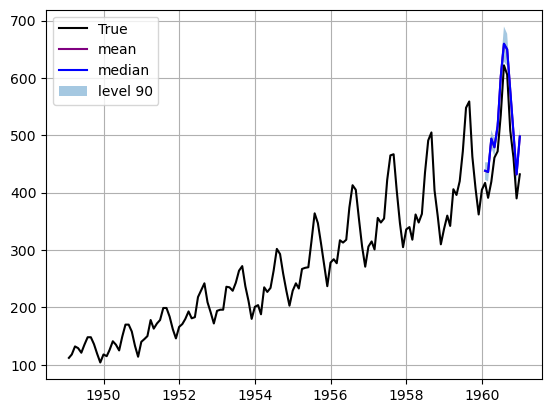

In [ ]:
#| eval: false
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from neuralforecast import NeuralForecast
#from neuralforecast.models import TFT
from neuralforecast.losses.pytorch import DistributionLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic

AirPassengersPanel['month']=AirPassengersPanel.ds.dt.month
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

nf = NeuralForecast(
    models=[TFT(h=12, input_size=48,
                hidden_size=20,
                loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
                learning_rate=0.005,
                stat_exog_list=['airline1'],
                futr_exog_list=['y_[lag12]','month'],
                hist_exog_list=['trend'],
                max_steps=300,
                val_check_steps=10,
                early_stop_patience_steps=10,
                scaler_type='robust',
                windows_batch_size=None,
                enable_progress_bar=True),
    ],
    freq='M'
)
nf.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
Y_hat_df = nf.predict(futr_df=Y_test_df)

# Plot quantile predictions
Y_hat_df = Y_hat_df.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['TFT'], c='purple', label='mean')
plt.plot(plot_df['ds'], plot_df['TFT-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:], 
                 y1=plot_df['TFT-lo-90'][-12:].values, 
                 y2=plot_df['TFT-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()

# Interpretability

## 1. Attention Weights

In [ ]:
#| eval: false
attention = nf.models[0].attention_weights()

In [ ]:
#| eval: false
def plot_attention(self, plot:str="time", output:str='plot', width:int=800, height:int=400):
        """
        Plot the attention weights.

        Args:
            plot (str, optional): The type of plot to generate. Can be one of the following:
                - 'time': Display the mean attention weights over time.
                - 'all': Display the attention weights for each horizon.
                - 'heatmap': Display the attention weights as a heatmap.
                - An integer in the range [1, model.h) to display the attention weights for a specific horizon.
            output (str, optional): The type of output to generate. Can be one of the following:
                - 'plot': Display the plot directly.
                - 'figure': Return the plot as a figure object.
            width (int, optional): Width of the plot in pixels. Default is 800.
            height (int, optional): Height of the plot in pixels. Default is 400.

        Returns:
            matplotlib.figure.Figure: If `output` is 'figure', the function returns the plot as a figure object.
        """

        attention = (
            self.mean_on_batch(self.interpretability_params["attn_wts"])
            .mean(dim=0)
            .cpu()
            .numpy()
        )

        fig, ax = plt.subplots(figsize=(width / 100, height / 100))

        if plot == "time":
            attention = attention[self.input_size:, :].mean(axis=0)
            ax.plot(np.arange(-self.input_size, self.h), attention)
            ax.axvline(x=0, color='black', linewidth=3, linestyle='--', label="prediction start")
            ax.set_title("Mean Attention")
            ax.set_xlabel("time")
            ax.set_ylabel("Attention")
            ax.legend()

        elif plot == "all":
            for i in range(self.input_size, attention.shape[0]):
                ax.plot(np.arange(-self.input_size, self.h), attention[i, :], label=f"horizon {i-self.input_size+1}")
            ax.axvline(x=0, color='black', linewidth=3, linestyle='--', label="prediction start")
            ax.set_title("Attention per horizon")
            ax.set_xlabel("time")
            ax.set_ylabel("Attention")
            ax.legend()

        elif plot == "heatmap":
            cax = ax.imshow(attention, aspect='auto', cmap='viridis',
                            extent=[-self.input_size, self.h, -self.input_size, self.h])
            fig.colorbar(cax)
            ax.set_title("Attention Heatmap")
            ax.set_xlabel("Attention (current time step)")
            ax.set_ylabel("Attention (previous time step)")

        elif isinstance(plot, int) and (plot in np.arange(1, self.h + 1)):
            i = self.input_size + plot - 1
            ax.plot(np.arange(-self.input_size, self.h), attention[i, :], label=f"horizon {plot}")
            ax.axvline(x=0, color='black', linewidth=3, linestyle='--', label="prediction start")
            ax.set_title(f"Attention weight for horizon {plot}")
            ax.set_xlabel("time")
            ax.set_ylabel("Attention")
            ax.legend()

        else:
            raise ValueError('plot has to be in ["time","all","heatmap"] or integer in range(1,model.h)')

        plt.tight_layout()

        if output == 'plot':
            plt.show()
        elif output == 'figure':
            return fig
        else:
            raise ValueError(f"Invalid output: {output}. Expected 'plot' or 'figure'.")

#### 1.1 Mean attention

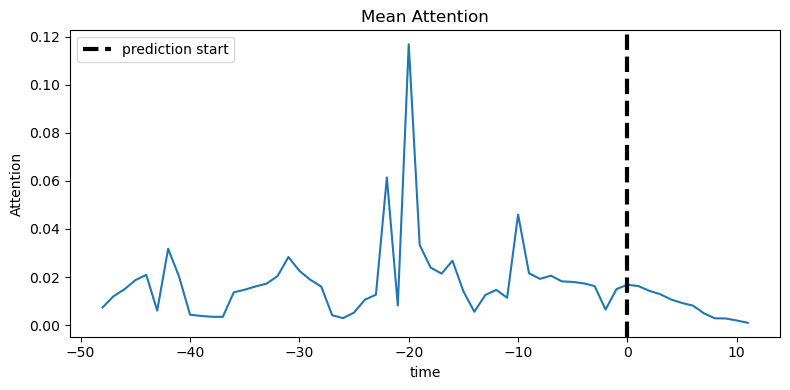

In [ ]:
#| eval: false
plot_attention(nf.models[0], plot="time")

#### 1.2 Attention of all future time steps

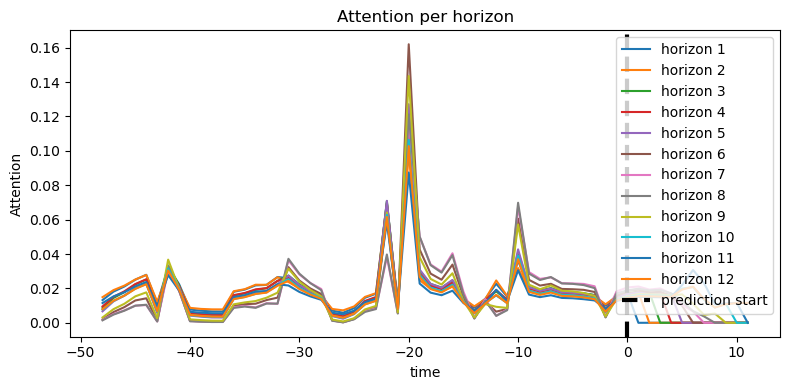

In [ ]:
#| eval: false
plot_attention(nf.models[0], plot="all")

#### 1.3 Attention of a specific future time step

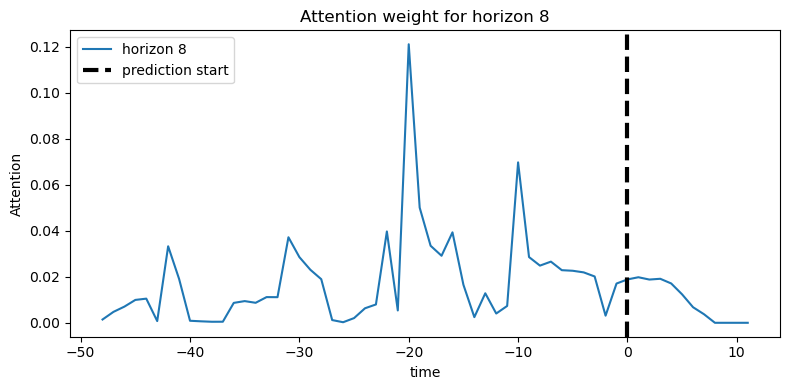

In [ ]:
#| eval: false
plot_attention(nf.models[0], plot=8)

## 2. Feature Importance
### 2.1 Global feature importance

In [ ]:
#| eval: false

feature_importances = nf.models[0].feature_importances()
feature_importances.keys()

dict_keys(['Past variable importance over time', 'Future variable importance over time', 'Static covariates'])

#### Static variable importances

<Axes: >

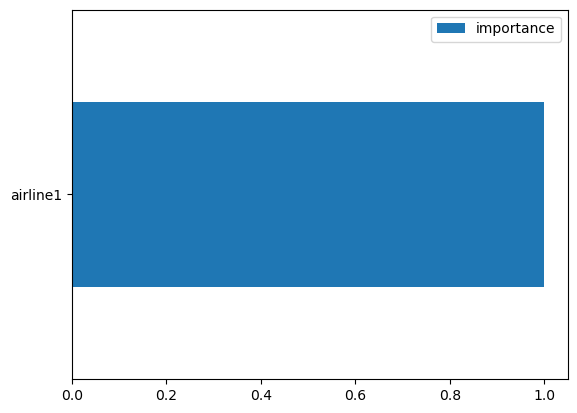

In [ ]:
#| eval: false
feature_importances['Static covariates'].sort_values(by='importance').plot(kind='barh')

#### Past variable importances

<Axes: >

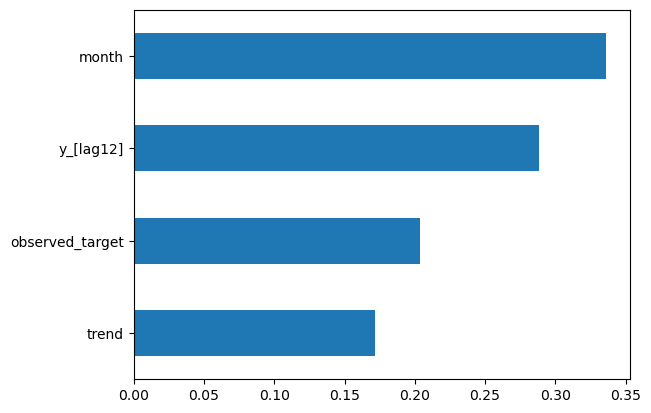

In [ ]:
#| eval: false
feature_importances['Past variable importance over time'].mean().sort_values().plot(kind='barh')

#### Future variable importances

<Axes: >

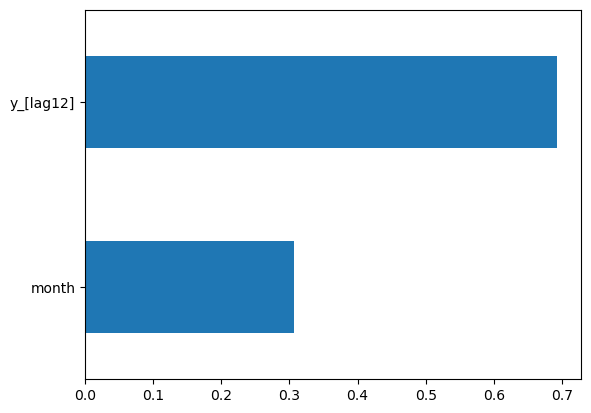

In [ ]:
#| eval: false
feature_importances['Future variable importance over time'].mean().sort_values().plot(kind='barh')

### 2.2 Variable importances over time

#### Future variable importance over time
Importance of each future covariate at each future time step

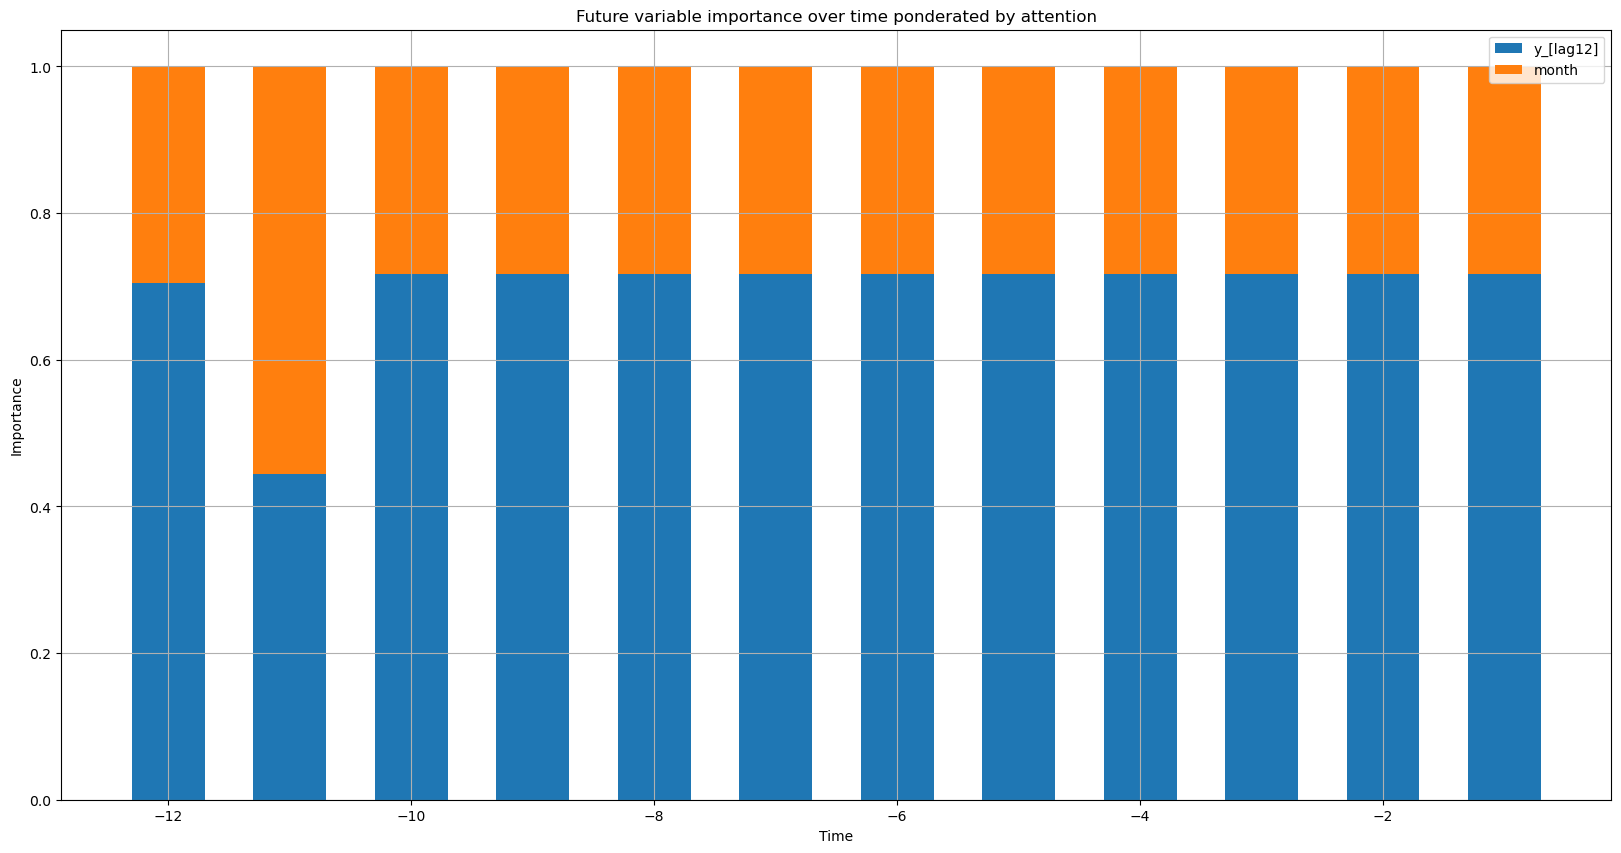

In [ ]:
#| eval: false
df=feature_importances['Future variable importance over time']


fig, ax = plt.subplots(figsize=(20, 10))
bottom = np.zeros(len(df.index))
for col in df.columns:
    p = ax.bar(np.arange(-len(df),0), df[col].values, 0.6, label=col, bottom=bottom)
    bottom += df[col]
ax.set_title('Future variable importance over time ponderated by attention')
ax.set_ylabel("Importance")
ax.set_xlabel("Time")
ax.grid(True)
ax.legend()
plt.show()

2.3

#### Past variable importance over time

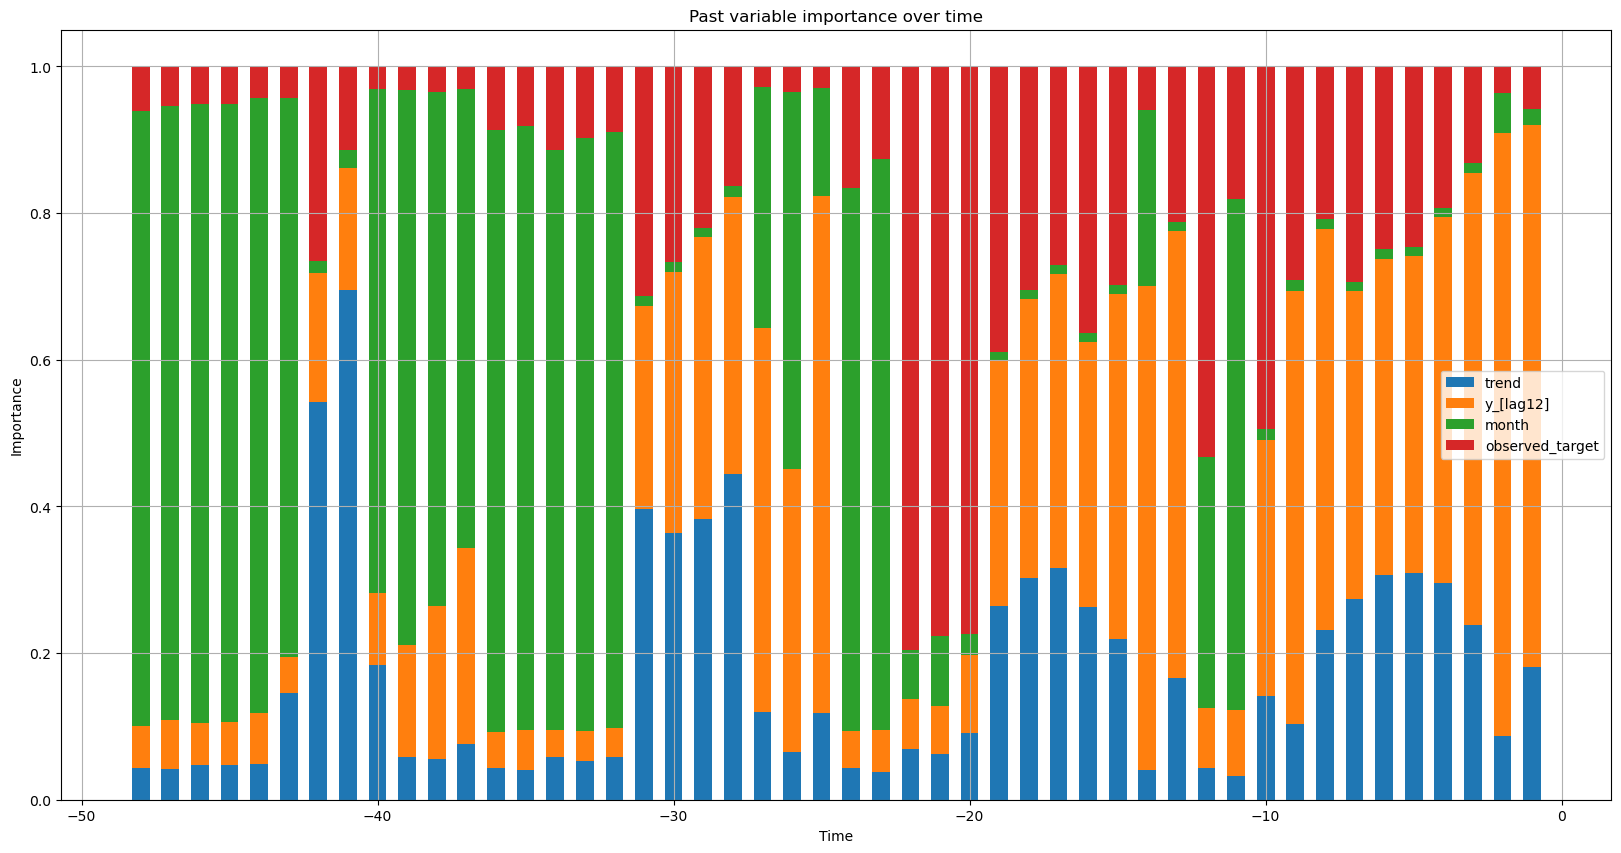

In [ ]:
#| eval: false
df= feature_importances['Past variable importance over time']

fig, ax = plt.subplots(figsize=(20, 10))
bottom = np.zeros(len(df.index))

for col in df.columns:
    p = ax.bar(np.arange(-len(df),0), df[col].values, 0.6, label=col, bottom=bottom)
    bottom += df[col]
ax.set_title('Past variable importance over time')
ax.set_ylabel("Importance")
ax.set_xlabel("Time")
ax.legend()
ax.grid(True)

plt.show()

#### Past variable importance over time ponderated by attention
Decomposition of the importance of each time step based on importance of each variable at that time step

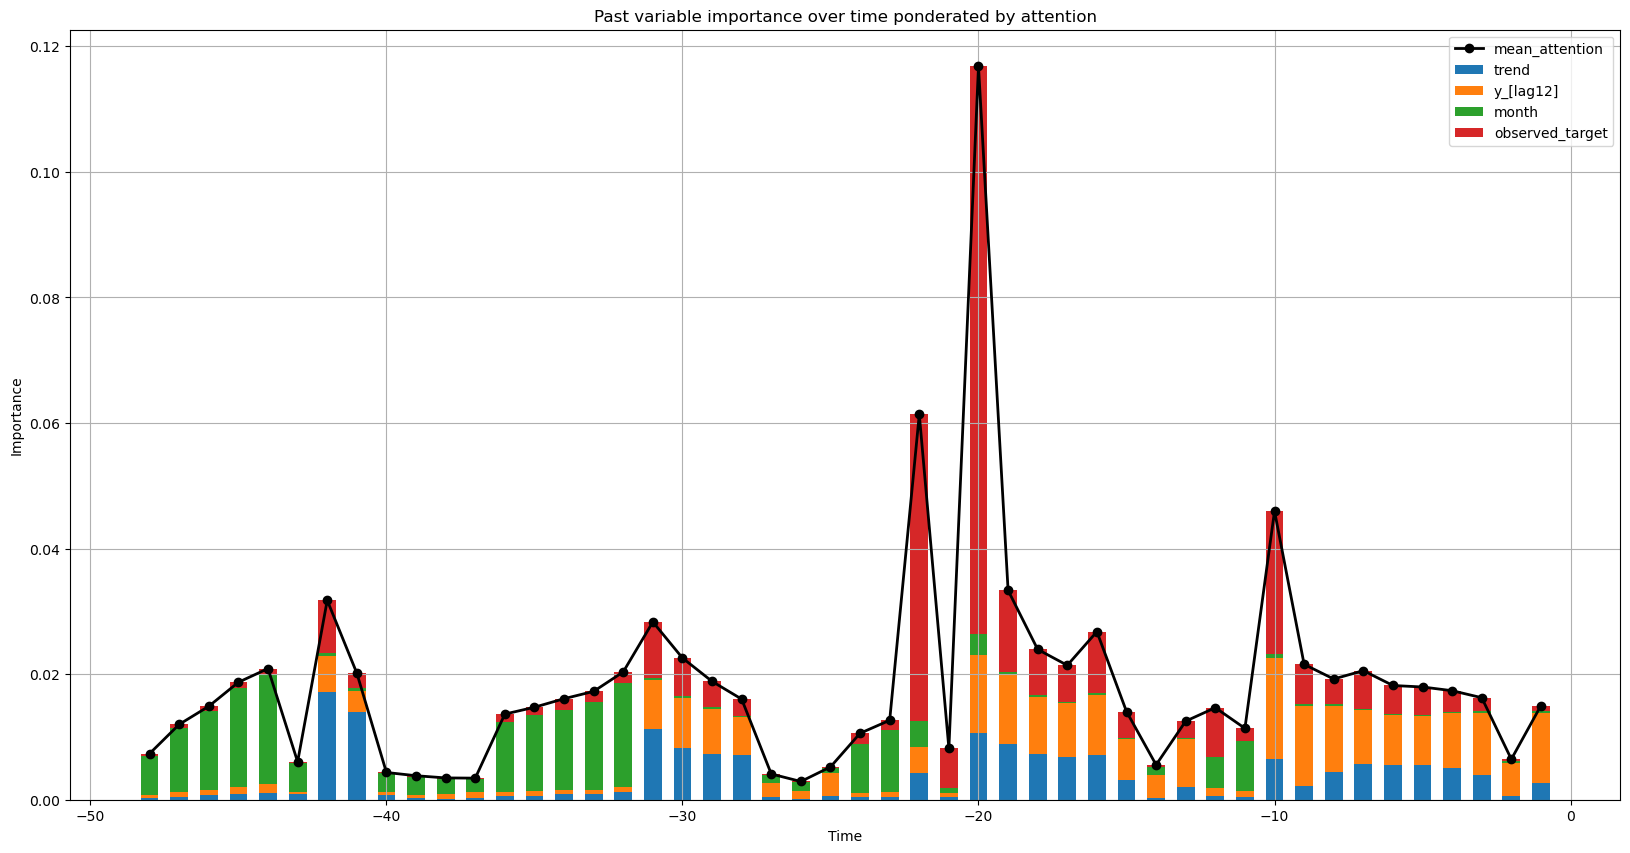

In [ ]:
#| eval: false
df= feature_importances['Past variable importance over time']
mean_attention = nf.models[0].attention_weights()[nf.models[0].input_size:,:].mean(axis=0)[:nf.models[0].input_size]
df = df.multiply(mean_attention, axis=0)

fig, ax = plt.subplots(figsize=(20, 10))
bottom = np.zeros(len(df.index))

for col in df.columns:
    p = ax.bar(np.arange(-len(df),0), df[col].values, 0.6, label=col, bottom=bottom)
    bottom += df[col]
ax.set_title('Past variable importance over time ponderated by attention')
ax.set_ylabel("Importance")
ax.set_xlabel("Time")
ax.legend()
ax.grid(True)
plt.plot(np.arange(-len(df),0), mean_attention, color='black', marker='o', linestyle='-', linewidth=2, label='mean_attention')
plt.legend()
plt.show()

### 3. Variable importance correlations over time
Variables which gain and lose importance at same moments

In [ ]:
#| eval: false
nf.models[0].feature_importance_correlations()

,trend,y_[lag12],month,observed_target,Correlation with Mean Attention
trend,1.00,0.52,-0.80,0.38,0.48
y_[lag12],0.52,1.00,-0.72,0.07,0.02
month,-0.80,-0.72,1.00,-0.62,-0.45
observed_target,0.38,0.07,-0.62,1.00,0.73
Correlation with Mean Attention,0.48,0.02,-0.45,0.73,1.00
